In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
tf.compat.v1.logging.set_verbosity(30)
tf.debugging.set_log_device_placement(True)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
physical_devices

In [4]:
df = pd.read_csv("data/porto.csv", index_col=[0], decimal=",")
df.dropna(inplace=True)
df = df.iloc[35136:35136*2]
df.drop(['Location'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df['Energy'] = df['Energy'].astype(np.float32)
df

,Energy
Time,
2019-01-01 00:00:00,2.322959
2019-01-01 00:15:00,2.371797
2019-01-01 00:30:00,2.415961
2019-01-01 00:45:00,2.302538
2019-01-01 01:00:00,2.363063
...,...
2020-01-01 22:45:00,2.244719
2020-01-01 23:00:00,2.136340
2020-01-01 23:15:00,2.192805


<Axes: xlabel='Time'>

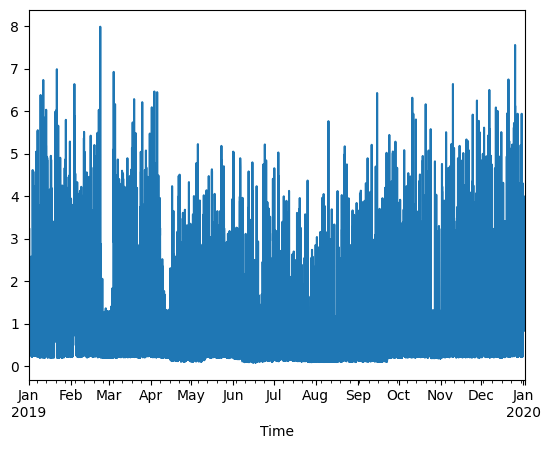

In [5]:
energy = df['Energy']
energy.plot()

In [6]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
WINDOW_SIZE = 672
X1, y1 = df_to_X_y(energy, WINDOW_SIZE)
X1.shape, y1.shape

((34464, 672, 1), (34464,))

In [8]:
X_train1, y_train1 = X1[:25000], y1[:25000]
X_val1, y_val1 = X1[25000:30000], y1[25000:30000]
X_test1, y_test1 = X1[30000:], y1[30000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((25000, 672, 1), (25000,), (5000, 672, 1), (5000,), (4464, 672, 1), (4464,))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as MSE
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((672, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [10]:
cp1 = ModelCheckpoint('models/model4', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MSE()])

In [11]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1], batch_size=2)

Epoch 1/10
12497/12500 [============================>.] - ETA: 0s - loss: 0.3339 - mean_squared_error: 0.3339

12500/12500 [==============================] - 233s 19ms/step - loss: 0.3340 - mean_squared_error: 0.3340 - val_loss: 0.2892 - val_mean_squared_error: 0.2892
Epoch 2/10
12499/12500 [============================>.] - ETA: 0s - loss: 0.2493 - mean_squared_error: 0.2493

12500/12500 [==============================] - 232s 19ms/step - loss: 0.2493 - mean_squared_error: 0.2493 - val_loss: 0.2762 - val_mean_squared_error: 0.2762
Epoch 3/10
12500/12500 [==============================] - ETA: 0s - loss: 0.2478 - mean_squared_error: 0.2478

12500/12500 [==============================] - 231s 18ms/step - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.2738 - val_mean_squared_error: 0.2738
Epoch 4/10
12500/12500 [==============================] - 227s 18ms/step - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.2823 - val_mean_squared_error: 0.2823
Epoch 5/10
12500/12500 [==============================] - ETA: 0s - loss: 0.2454 - mean_squared_error: 0.2454

12500/12500 [==============================] - 233s 19ms/step - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.2734 - val_mean_squared_error: 0.2734
Epoch 6/10
12500/12500 [==============================] - 230s 18ms/step - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.2774 - val_mean_squared_error: 0.2774
Epoch 7/10
12497/12500 [============================>.] - ETA: 0s - loss: 0.2419 - mean_squared_error: 0.2419

12500/12500 [==============================] - 233s 19ms/step - loss: 0.2420 - mean_squared_error: 0.2420 - val_loss: 0.2719 - val_mean_squared_error: 0.2719
Epoch 8/10
12497/12500 [============================>.] - ETA: 0s - loss: 0.2404 - mean_squared_error: 0.2404

12500/12500 [==============================] - 229s 18ms/step - loss: 0.2404 - mean_squared_error: 0.2404 - val_loss: 0.2701 - val_mean_squared_error: 0.2701
Epoch 9/10
12500/12500 [==============================] - 228s 18ms/step - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2753 - val_mean_squared_error: 0.2753
Epoch 10/10
12500/12500 [==============================] - 229s 18ms/step - loss: 0.2409 - mean_squared_error: 0.2409 - val_loss: 0.2724 - val_mean_squared_error: 0.2724


In [26]:
from tensorflow.keras.models import load_model
model1 = load_model('models/model4')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [27]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

782/782 [==============================] - 7s 8ms/step


,Train Predictions,Actuals
0,1.412308,1.243963
1,1.284599,1.289234
2,1.359125,1.253928
3,1.298767,1.233753
4,1.312026,1.287758
...,...,...
24995,0.258236,0.325507
24996,0.340006,1.145672
24997,1.231276,1.231046
24998,1.136140,0.596763


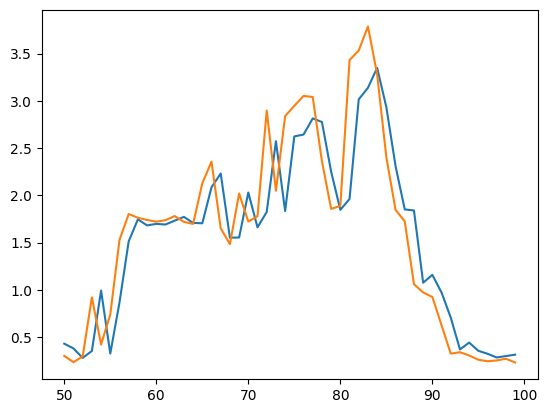

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [29]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

157/157 [==============================] - 1s 9ms/step


,Val Predictions,Actuals
0,0.339509,0.259815
1,0.319263,0.315050
2,0.384053,0.272609
3,0.307771,0.202242
4,0.247817,0.232013
...,...,...
4995,0.315796,0.356754
4996,0.427203,0.234104
4997,0.305167,0.258339
4998,0.377863,0.274700


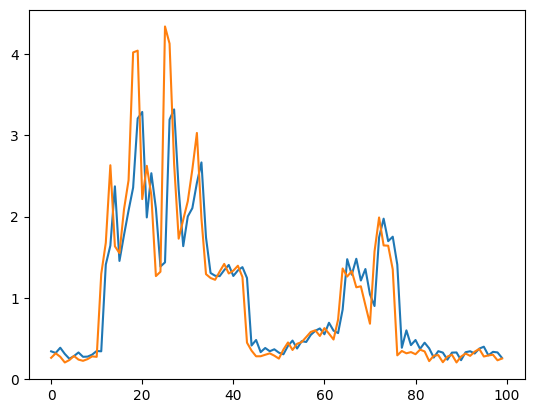

In [30]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [31]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

140/140 [==============================] - 1s 8ms/step


,Test Predictions,Actuals
0,0.375287,0.271133
1,0.442196,0.264121
2,0.440370,0.287986
3,0.489513,0.332765
4,0.543447,0.696285
...,...,...
4459,3.111927,2.244719
4460,2.065665,2.136340
4461,2.337878,2.192805
4462,2.166309,1.446083


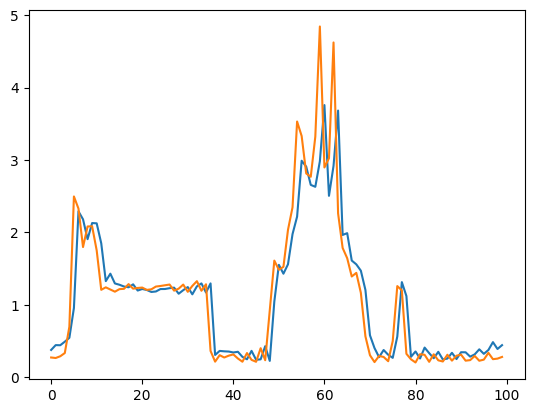

In [32]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [33]:
## mostrar erro (diferencça entre real e simulado)

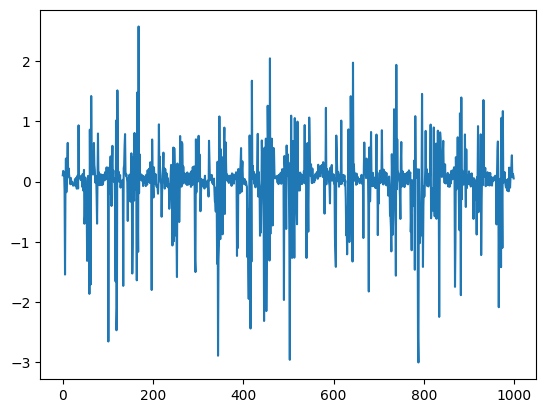

In [34]:
diff = test_results['Test Predictions'] - test_results['Actuals']
#plt.plot(range(test_results.shape[0]), diff)
plt.plot(range(1000), diff[:1000])

In [35]:
def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 

In [36]:
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

In [37]:
performance_metrics(train_results['Train Predictions'], train_results['Actuals'])

MSE: 0.2381
WAPE: 30.03
R2: 0.7429


(0.2381, 30.03, 0.7429)

In [38]:
performance_metrics(val_results['Val Predictions'], val_results['Actuals'])

MSE: 0.2701
WAPE: 27.87
R2: 0.7334


(0.2701, 27.87, 0.7334)

In [39]:
performance_metrics(test_results['Test Predictions'], test_results['Actuals'])

MSE: 0.3654
WAPE: 24.86
R2: 0.7266


(0.3654, 24.86, 0.7266)